In [20]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport

#from rdkit import Chem
#from rdkit.Chem.Draw import IPythonConsole
#from rdkit.Chem import Draw

import shap
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor



from sklearn.metrics import make_scorer ,mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, max_error

from scipy.stats import skew

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate , cross_val_score

In [2]:
data= pd.read_csv("data\CEPDB_25000.csv")

In [3]:
data.head()

,id,SMILES_str,stoich_str,mass,pce,voc,jsc,e_homo_alpha,e_gap_alpha,e_lumo_alpha,tmp_smiles_str,ml_phase
0,1503301,C1C=c2c-3c([SiH2]c4cc[nH]c-34)c3cnc(cc3c2=C1)-...,C21H13N5SSi,395.5207,8.236346,0.641905,197.474780,-5.241905,1.463722,-3.778183,[nH]1ccc2[SiH2]c3c(-c12)c1=CCC=c1c1cc(ncc31)-c...,train
1,2540778,[SiH2]1C=c2ccc3sc4c([nH]c5cc(-c6scc7C=C[SiH2]c...,C24H17NS2Si3,467.7953,5.738034,0.427601,206.524926,-5.027601,1.427000,-3.600601,[nH]1c2cc(-c3scc4C=C[SiH2]c34)c3=C[SiH2]C=c3c2...,train
2,615142,c1[nH]cc2c1ccc1cnc3cc4cc([se]c4cc3c21)-c1ncncn1,C20H11N5Se,400.3019,5.038762,0.873908,88.737230,-5.473908,2.042885,-3.431022,c1cc2cnc3cc4cc([se]c4cc3c2c2c[nH]cc12)-c1ncncn1,train
3,124449,C1C=c2c(cc3ccc4c5cnccc5c5cocc5c4c3c2=C1)-c1cccs1,C26H15NOS,389.4765,3.507048,0.732531,73.682314,-5.332531,2.162777,-3.169754,c1ccc(s1)-c1cc2ccc3c4cnccc4c4cocc4c3c2c2=CCC=c12,train
4,1008442,C1cc2ccc3sc4cc5ccc6c[SiH2]cc6c5cc4c3c2c1,C21H14SSi,326.4936,4.020859,0.630730,98.112205,-5.230730,1.978195,-3.252535,c1cc2sc3cc4ccc5c[SiH2]cc5c4cc3c2c2cCcc12,train


In [4]:
data.columns

Index(['id', 'SMILES_str', 'stoich_str', 'mass', 'pce', 'voc', 'jsc',
       'e_homo_alpha', 'e_gap_alpha', 'e_lumo_alpha', 'tmp_smiles_str',
       'ml_phase'],
      dtype='object')

In [5]:
data=data.drop(["ml_phase","id"],axis=1)

In [6]:
data

,SMILES_str,stoich_str,mass,pce,voc,jsc,e_homo_alpha,e_gap_alpha,e_lumo_alpha,tmp_smiles_str
0,C1C=c2c-3c([SiH2]c4cc[nH]c-34)c3cnc(cc3c2=C1)-...,C21H13N5SSi,395.5207,8.236346,0.641905,197.474780,-5.241905,1.463722,-3.778183,[nH]1ccc2[SiH2]c3c(-c12)c1=CCC=c1c1cc(ncc31)-c...
1,[SiH2]1C=c2ccc3sc4c([nH]c5cc(-c6scc7C=C[SiH2]c...,C24H17NS2Si3,467.7953,5.738034,0.427601,206.524926,-5.027601,1.427000,-3.600601,[nH]1c2cc(-c3scc4C=C[SiH2]c34)c3=C[SiH2]C=c3c2...
2,c1[nH]cc2c1ccc1cnc3cc4cc([se]c4cc3c21)-c1ncncn1,C20H11N5Se,400.3019,5.038762,0.873908,88.737230,-5.473908,2.042885,-3.431022,c1cc2cnc3cc4cc([se]c4cc3c2c2c[nH]cc12)-c1ncncn1
3,C1C=c2c(cc3ccc4c5cnccc5c5cocc5c4c3c2=C1)-c1cccs1,C26H15NOS,389.4765,3.507048,0.732531,73.682314,-5.332531,2.162777,-3.169754,c1ccc(s1)-c1cc2ccc3c4cnccc4c4cocc4c3c2c2=CCC=c12
4,C1cc2ccc3sc4cc5ccc6c[SiH2]cc6c5cc4c3c2c1,C21H14SSi,326.4936,4.020859,0.630730,98.112205,-5.230730,1.978195,-3.252535,c1cc2sc3cc4ccc5c[SiH2]cc5c4cc3c2c2cCcc12
...,...,...,...,...,...,...,...,...,...,...
24995,C1C=c2ccc3[SiH2]c4c([nH]c5cc(oc45)-c4scc5[SiH2...,C21H15NOSSi2,385.5935,2.045460,0.156053,201.727494,-4.756053,1.445501,-3.310552,[nH]1c-2c([SiH2]c3ccc4=CCC=c4c-23)c2oc(cc12)-c...
24996,C1C=c2ccc3cc4[se]c5C=C(Cc5c4cc3c2=C1)C1=CC=CC1,C23H16Se,371.3394,2.097438,0.292111,110.506690,-4.892111,1.901301,-2.990811,C1=CC=C(C1)C1=Cc2[se]c3cc4ccc5=CCC=c5c4cc3c2C1
24997,C1C=Cc2ccc3c(sc4cc(-c5nccs5)c5c[nH]cc5c34)c12,C20H12N2S2,344.4608,2.183358,0.434750,77.291785,-5.034750,2.132758,-2.901991,C1=Cc2ccc3c(sc4cc(-c5nccs5)c5c[nH]cc5c34)c2C1
24998,c-1c[s]-c2c-1ccc1c3ncccc3c3ccccc3c21,C19H11NS,285.3689,0.486618,1.304193,5.742402,-5.904193,3.278545,-2.625648,c1c-c2ccc3c4ncccc4c4ccccc4c3c2-[s]1


# Data Cleaning


This dataset was already maximally pre-processed (https://www.repository.cam.ac.uk/handle/1810/318115) and stratified sampling was then applied to derive a set of 25,000 candidate CSO donors for computational reasons

In [7]:
data.tmp_smiles_str

0        [nH]1ccc2[SiH2]c3c(-c12)c1=CCC=c1c1cc(ncc31)-c...
1        [nH]1c2cc(-c3scc4C=C[SiH2]c34)c3=C[SiH2]C=c3c2...
2          c1cc2cnc3cc4cc([se]c4cc3c2c2c[nH]cc12)-c1ncncn1
3         c1ccc(s1)-c1cc2ccc3c4cnccc4c4cocc4c3c2c2=CCC=c12
4                 c1cc2sc3cc4ccc5c[SiH2]cc5c4cc3c2c2cCcc12
                               ...                        
24995    [nH]1c-2c([SiH2]c3ccc4=CCC=c4c-23)c2oc(cc12)-c...
24996       C1=CC=C(C1)C1=Cc2[se]c3cc4ccc5=CCC=c5c4cc3c2C1
24997        C1=Cc2ccc3c(sc4cc(-c5nccs5)c5c[nH]cc5c34)c2C1
24998                  c1c-c2ccc3c4ncccc4c4ccccc4c3c2-[s]1
24999    c1sc(-c2sc(-c3ccc(cn3)-c3ccccn3)c3ccCc23)c2sccc12
Name: tmp_smiles_str, Length: 25000, dtype: object

# Information about dataset
* Distribution of reported PCE
* Schematics of expressions of somes molecules

In [8]:
data.describe()

,mass,pce,voc,jsc,e_homo_alpha,e_gap_alpha,e_lumo_alpha
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000
mean,415.560570,4.126613,0.579165,123.320601,-5.179165,1.895249,-3.283916
std,59.575976,2.407685,0.285351,64.269393,0.285351,0.396566,0.366131
min,172.186200,0.000109,0.000012,3.882689,-6.496841,0.799452,-3.999917
25%,379.437700,2.247589,0.373424,72.329945,-5.361342,1.607647,-3.568905
50%,415.558800,3.582067,0.555968,114.218791,-5.155968,1.877308,-3.278469
75%,455.588700,5.739375,0.761342,164.150991,-4.973424,2.172793,-3.013955
max,639.465000,11.097616,1.896841,354.253069,-4.600012,3.402620,-1.629426


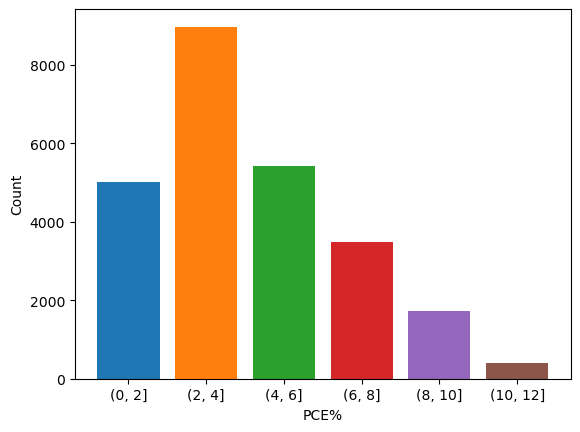

In [9]:
data['pce_pair'] = pd.cut(data['pce'], bins=[0, 2, 4, 6, 8, 10,12])
pce_count = data.groupby('pce_pair').size()

colors = plt.cm.tab10(np.arange(len(pce_count)))

plt.bar(pce_count.index.astype(str), pce_count.values, color=colors)
plt.xlabel('PCE%')
plt.ylabel('Count')
plt.show()



In [10]:
#print(data['SMILES_str'][0])
#Chem.MolFromSmiles(data['SMILES_str'][0])

* Additionals informations

In [11]:
profile = ProfileReport(
    data,
    title="Profiling Report",
    html={'style':{'full_width':True}}
)

profile.to_file(output_file = "data-profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Feature Engineering

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


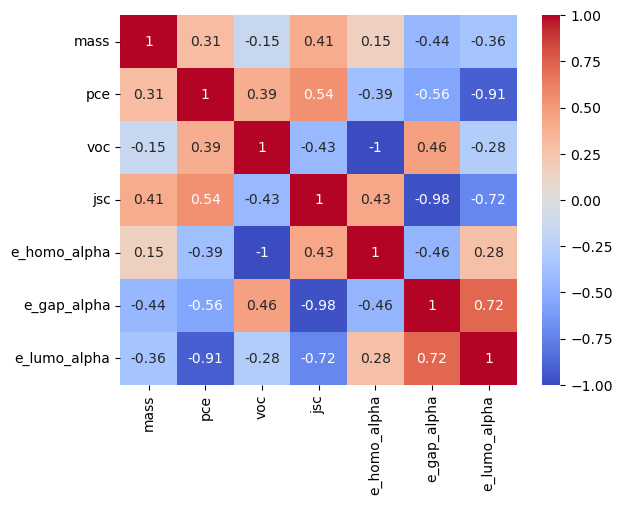

In [12]:
corr_matrix = data.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.show()

Feature importance using SHAP values based on

* XGBoost
* Random Forest
* Desicion Trees
* K-nearest neighbors

In [13]:
X=data.drop(["SMILES_str","stoich_str","pce","tmp_smiles_str","pce_pair"],axis=1)
y=data["pce"]

In [ ]:
# With XGBOOST
model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(X, y)

explainer = shap.Explainer(model)
shap_values = explainer(X)

shap.summary_plot(shap_values, X, plot_type='bar', show=False)

In [ ]:
# With Random Forest
from sklearn.ensemble import RandomForestRegressor

# Instantiate rf
rf = RandomForestRegressor(n_estimators=25,random_state=2)
            
# Fit rf to the training set    
rf.fit(X, y) 

# Create a SHAP object by using TreeExplainer
explainer = shap.TreeExplainer(rf)

# Call the explain method by using entry data
shap_values = explainer(X)

# Display a barplot which show the importance of each features
shap.summary_plot(shap_values, X, plot_type='bar', show=False)


# Model Construction 

To select the appropriate regression model , we must train and validate differents models on our train/validation data and compare the metrics

* XGBoost
* Random Forest
* Desicion Trees
* K-nearest neighbors

In [16]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

# We can drop mass & e_homo_alpha because they have no impact on the ouptut
X=data.drop(["SMILES_str","stoich_str","pce","tmp_smiles_str","pce_pair","mass", "e_homo_alpha"],axis=1)

# Split dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3 ,random_state=42)

# Instantiate rf
rf = RandomForestRegressor(n_estimators=25, random_state=2)
            
# Fit rf to the training set    
rf.fit(X_train, y_train) 

# Predict the test set labels
y_pred = rf.predict(X_test)

# Evaluate the test set RMSE
rmse_test =  MSE(y_test, y_pred)**(1/2)

# Print rmse_test
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))

Test set RMSE of rf: 0.04
